# Record Linkage Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

In [6]:
from entity_embed.benchmarks import AmazonGoogleBenchmark

benchmark = AmazonGoogleBenchmark(data_dir_path="data/")
benchmark

18:52:58 INFO:Extracting Amazon-Google...
18:52:58 INFO:Reading Amazon-Google record_dict...
18:52:58 INFO:Reading Amazon-Google train.csv...
18:52:59 INFO:Reading Amazon-Google valid.csv...
18:52:59 INFO:Reading Amazon-Google test.csv...


## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, and strip leading and trailing whitespace.

The fields we'll clean are the ones we'll use:

In [7]:
field_list = ['title', 'manufacturer', 'price']

In [8]:
import unidecode

def clean_str(s):
    return unidecode.unidecode(s).lower().strip()

for record_dict in [benchmark.train_record_dict, benchmark.valid_record_dict, benchmark.test_record_dict]:
    for record in record_dict.values():
        for field in field_list:
            record[field] = clean_str(record[field])

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

## Configure Entity Embed fields

Now we will define how record fields will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [9]:
from entity_embed.data_utils.field_config_parser import DEFAULT_ALPHABET

alphabet = DEFAULT_ALPHABET
''.join(alphabet)

'0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

It's worth noting you can use any alphabet you need, so the accent removal we performed is optional.

Then we set an `field_config_dict`. It defines `field_type`s that determine how fields are processed in the neural network:

In [10]:
field_config_dict = {
    'title': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'title_semantic': {
        'key': 'title',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    }
}

Then we use our `field_config_dict` to get a `record_numericalizer`. This object will convert the strings from our records into tensors for the neural network.

The same `record_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Therefore, we pass `record_list=record_dict.values()`:

In [11]:
from entity_embed import FieldConfigDictParser

record_numericalizer = FieldConfigDictParser.from_dict(
    field_config_dict,
    record_list={
        **benchmark.train_record_dict, 
        **benchmark.valid_record_dict,
        **benchmark.test_record_dict
    }.values())

18:52:59 INFO:For field=title, computing actual max_str_len
18:52:59 INFO:For field=title, using actual_max_str_len=26
18:52:59 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
18:53:02 INFO:For field=manufacturer, computing actual max_str_len
18:53:02 INFO:actual_max_str_len=15 must be even to enable NN pooling. Updating to 16
18:53:02 INFO:For field=manufacturer, using actual_max_str_len=16
18:53:02 INFO:For field=price, computing actual max_str_len
18:53:02 INFO:actual_max_str_len=9 must be even to enable NN pooling. Updating to 10
18:53:02 INFO:For field=price, using actual_max_str_len=10


## Initialize Data Module

In [12]:
batch_size = 32
eval_batch_size = 64
datamodule = benchmark.build_datamodule(
    record_numericalizer=record_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    random_seed=random_seed
)

## Training

Now the training process! Thanks to pytorch-lightning, it's easy to train, validate, and test with the same datamodule.

We must choose the K of the Approximate Nearest Neighbors, i.e., the top K neighbors our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `LinkageEmbed` model object:

In [13]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    record_numericalizer,
    ann_k=ann_k,
    source_field=benchmark.source_field,
    left_source=benchmark.left_source,
)

In [14]:
model

LinkageEmbed(
  (blocker_net): BlockerNet(
    (field_embed_net): FieldsEmbedNet(
      (embed_net_dict): ModuleDict(
        (title): MultitokenAttentionEmbed(
          (embed_net): StringEmbedCNN(
            (conv): Sequential(
              (0): Conv1d(69, 552, kernel_size=(3,), stride=(1,), padding=(1,), groups=69, bias=False)
              (1): ReLU()
              (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            )
            (dense_net): Sequential(
              (0): Linear(in_features=7176, out_features=300, bias=True)
              (1): Dropout(p=0.2, inplace=False)
            )
          )
          (gru): GRU(300, 150, batch_first=True, bidirectional=True)
          (attention_net): MaskedAttention()
        )
        (title_semantic): MultitokenAttentionEmbed(
          (embed_net): SemanticEmbedNet(
            (dense_net): Sequential(
              (0): Embedding(3441, 300)
              (1): Dropout(p=0.2, inplace=False)
   

To train, Entity Embed uses [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) on it's `LinkageEmbed.fit` method.

Since Entity Embed is focused in recall, we'll use `valid_recall_at_0.4` for early stopping. But we'll set `min_epochs = 10` to avoid a very low precision.

`0.4` here is the threshold for **cosine similarity of embedding vectors**, so possible values are between -1 and 1. We're using a validation metric, and the training process will run validation on every epoch end due to `check_val_every_n_epoch=1`.

We also set `tb_name` and `tb_save_dir` to use Tensorboard. Run `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics during and after training.

In [15]:
trainer = model.fit(
    datamodule,
    min_epochs=10,
    max_epochs=100,
    check_val_every_n_epoch=1,
    early_stop_monitor="valid_recall_at_0.3",
    tb_save_dir='tb_logs',
    tb_name=f'benchmark-{benchmark.dataset_name}',
)

18:53:02 INFO:GPU available: True, used: True
18:53:02 INFO:TPU available: False, using: 0 TPU cores
18:53:02 INFO:Train positive pair count: 699
18:53:02 INFO:Valid positive pair count: 234
18:53:02 INFO:Valid negative pair count: 2059
18:53:02 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
18:53:13 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 6.6 M 
1 | loss_fn     | NTXentLoss | 0     
-------------------------------------------
5.5 M     Trainable params
1.0 M     Non-trainable params
6.6 M     Total params
26.263    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

18:56:10 INFO:Loading the best validation model from tb_logs/benchmark-Amazon-Google/version_17/checkpoints/epoch=18-step=835.ckpt...


`LinkageEmbed.fit` keeps only the weights of the best validation model. With them, we can check the best performance on validation set:

In [16]:
model.validate(datamodule)

{'valid_f1_at_0.3': 0.24814422057264052,
 'valid_f1_at_0.5': 0.39649122807017545,
 'valid_f1_at_0.7': 0.5722543352601156,
 'valid_pair_entity_ratio_at_0.3': 0.8791910590739755,
 'valid_pair_entity_ratio_at_0.5': 0.48217136774880254,
 'valid_pair_entity_ratio_at_0.7': 0.2437466737626397,
 'valid_precision_at_0.3': 0.14164648910411623,
 'valid_precision_at_0.5': 0.24944812362030905,
 'valid_precision_at_0.7': 0.43231441048034935,
 'valid_recall_at_0.3': 1.0,
 'valid_recall_at_0.5': 0.9658119658119658,
 'valid_recall_at_0.7': 0.8461538461538461}

And we can check which fields are most important for the final embedding:

In [17]:
model.get_pool_weights()

{'title': 0.33356332778930664,
 'title_semantic': 0.3306666612625122,
 'manufacturer': 0.15299515426158905,
 'price': 0.18277479708194733}

## Testing

Again with the best validation model, we can check the performance on the test set:

In [18]:
model.test(datamodule)

18:56:19 INFO:Test positive pair count: 234
18:56:19 INFO:Test negative pair count: 234


{'test_f1_at_0.3': 0.24709609292502638,
 'test_f1_at_0.5': 0.39545056867891515,
 'test_f1_at_0.7': 0.5814977973568282,
 'test_pair_entity_ratio_at_0.3': 0.891993551853842,
 'test_pair_entity_ratio_at_0.5': 0.48844707146695326,
 'test_pair_entity_ratio_at_0.7': 0.24019344438473939,
 'test_precision_at_0.3': 0.14096385542168674,
 'test_precision_at_0.5': 0.24862486248624863,
 'test_precision_at_0.7': 0.4429530201342282,
 'test_recall_at_0.3': 1.0,
 'test_recall_at_0.5': 0.9658119658119658,
 'test_recall_at_0.7': 0.8461538461538461}

Entity Embed achieves Recall of ~0.99 with Pair-Entity ratio below 100 on a variety of datasets. **Entity Embed aims for high recall at the expense of precision. Therefore, this library is suited for the Blocking/Indexing stage of an Entity Resolution pipeline.**  A scalabale and noise-tolerant Blocking procedure is often the main bottleneck for performance and quality on Entity Resolution pipelines, so this library aims to solve that. Note the ANN search on embedded records returns several candidate pairs that must be filtered to find the best matching pairs, possibly with a pairwise classifier. See [Matching](#Matching) section below

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered. First, get the embedding vectors:

In [19]:
test_record_dict = benchmark.test_record_dict
test_left_vector_dict, test_right_vector_dict = model.predict(
    record_dict=test_record_dict,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/30 [00:00<?, ?it/s]

Then, produce the visualization:

In [20]:
vis_sample_size = 10

In [21]:
from entity_embed.data_utils import utils

test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
__, test_cluster_dict = utils.id_pairs_to_cluster_mapping_and_dict(benchmark.test_pos_pair_set, test_record_dict)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [22]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [23]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=15, square_distances=True, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

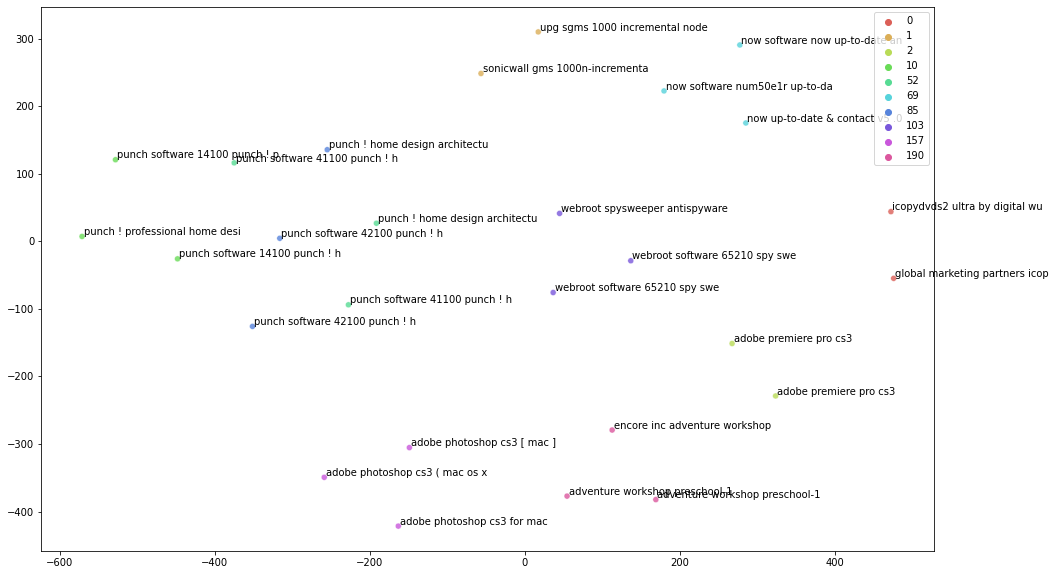

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_record_dict[id_]['title'][:30]
    ax.text(x + 2, y + 2, text)

## Testing manually (like a production run)

In [25]:
import copy

prod_test_record_dict = copy.deepcopy(test_record_dict)

Then call `predict_pairs` with some `ann_k` and `sim_threshold`:

In [26]:
sim_threshold = 0.3

found_pair_set = model.predict_pairs(
    record_dict=prod_test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold
)
len(found_pair_set)

# batch embedding:   0%|          | 0/30 [00:00<?, ?it/s]

19715

Let's check now the metrics of the found duplicate pairs:

In [27]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(found_pair_set, prod_test_record_dict, datamodule.test_pos_pair_set, datamodule.test_neg_pair_set)

0.891993551853842

In [28]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, datamodule.test_pos_pair_set, datamodule.test_neg_pair_set)

(0.14096385542168674, 1.0)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [29]:
false_positives = list(found_pair_set - datamodule.test_pos_pair_set)
len(false_positives)

19481

In [30]:
false_negatives = list(datamodule.test_pos_pair_set - found_pair_set)
len(false_negatives)

0

In [31]:
cos_similarity = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [32]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )

(0.36492172,
 {'title': 'the print shop design suite pro ed sb cs by the print shop',
  'manufacturer': 'encore software',
  'price': '199.99'},
 {'title': 'cisco csa-b100-srvr-k9 cisco security server agent win + sol 100 agentbundle cisco security server agent license 100 agents win solaris 0746320832586',
  'manufacturer': '',
  'price': '55288.67'})

(0.82887805,
 {'title': 'print explosion deluxe 3.0 ( mac )',
  'manufacturer': 'nova development',
  'price': '49.99'},
 {'title': 'photo explosion deluxe ( r ) 2.0',
  'manufacturer': '',
  'price': '49.99'})

(0.38604733,
 {'title': 'filemaker mobile 8 for palm os and pocket pc',
  'manufacturer': 'filemaker',
  'price': '69.0'},
 {'title': 'filemaker pro 8.5 upgrade', 'manufacturer': '', 'price': '169.99'})

In [34]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )